# Principal

In [3]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-


import numpy as np
import platform
import tempfile
import os
import matplotlib.pyplot as plt
from scipy import ndimage as ndi
# necessite scikit-image 
from skimage import io as skio


def viewimage(im, normalise=True, MINI=0.0, MAXI=255.0):
    """ Cette fonction fait afficher l'image EN NIVEAUX DE GRIS 
        dans gimp. Si un gimp est deja ouvert il est utilise.
        Par defaut normalise=True. Et dans ce cas l'image est normalisee 
        entre 0 et 255 avant d'être sauvegardee.
        Si normalise=False MINI et MAXI seront mis a 0 et 255 dans l'image resultat
        
    """
    imt = np.float32(im.copy())
    if platform.system() == 'Darwin':  #on est sous mac
        prephrase = 'open -a GIMP '
        endphrase = ' '
    elif platform.system() == 'Windows':
        #ou windows ; probleme : il faut fermer gimp pour reprendre la main; 
        #si vous savez comment faire (commande start ?) je suis preneur 
        prephrase = '"C:/Users/juane/AppData/Local/Programs/GIMP 2/bin/gimp-2.10.exe" '
        endphrase = ' '
    else:  #SINON ON SUPPOSE LINUX (si vous avez un windows je ne sais pas comment faire. Si vous savez dites-moi.)
        prephrase = 'gimp '
        endphrase = ' &'

    if normalise:
        m = im.min()
        imt = imt - m
        M = imt.max()
        if M > 0:
            imt = 255 * imt / M

    else:
        imt = (imt - MINI) / (MAXI - MINI)
        imt[imt < 0] = 0
        imt[imt > 1] = 1
        imt *= 255

    nomfichier = tempfile.mktemp('TPIMA.png')
    commande = prephrase + nomfichier + endphrase
    imt = imt.astype(np.uint8)
    skio.imsave(nomfichier, imt)
    os.system(commande)


def viewimage_color(im, normalise=True, MINI=0.0, MAXI=255.0):
    """ Cette fonction fait afficher l'image EN NIVEAUX DE GRIS 
        dans gimp. Si un gimp est deja ouvert il est utilise.
        Par defaut normalise=True. Et dans ce cas l'image est normalisee 
        entre 0 et 255 avant d'être sauvegardee.
        Si normalise=False MINI(defaut 0) et MAXI (defaut 255) seront mis a 0 et 255 dans l'image resultat
        
    """
    imt = np.float32(im.copy())
    if platform.system() == 'Darwin':  #on est sous mac
        prephrase = 'open -a GIMP '
        endphrase = ' '
    elif platform.system() == 'Windows':
        #ou windows ; probleme : il faut fermer gimp pour reprendre la main; 
        #si vous savez comment faire (commande start ?) je suis preneur 
        prephrase = '"C:/Users/juane/AppData/Local/Programs/GIMP 2/bin/gimp-2.10.exe" '
        endphrase = ' '
    else:  #SINON ON SUPPOSE LINUX (si vous avez un windows je ne sais comment faire. Si vous savez dites-moi.)
        prephrase = 'gimp '
        endphrase = ' &'

    if normalise:
        m = imt.min()
        imt = imt - m
        M = imt.max()
        if M > 0:
            imt = 255 * imt / M
    else:
        imt = (imt - MINI) / (MAXI - MINI)
        imt[imt < 0] = 0
        imt[imt > 1] = 1
        imt *= 255

    nomfichier = tempfile.mktemp('TPIMA.pgm')
    commande = prephrase + nomfichier + endphrase
    imt = imt.astype(np.uint8)
    skio.imsave(nomfichier, imt)
    os.system(commande)


def noise(im, br):
    """ Cette fonction ajoute un bruit blanc gaussier d'ecart type br
       a l'image im et renvoie le resultat"""
    imt = np.float32(im.copy())
    sh = imt.shape
    bruit = br * np.random.randn(*sh)
    imt = imt + bruit
    return imt


def quantize(im, n=2):
    """
    Renvoie une version quantifiee de l'image sur n (=2 par defaut) niveaux  
    """
    imt = np.float32(im.copy())
    if np.floor(n) != n or n < 2:
        raise Exception("La valeur de n n'est pas bonne dans quantize")
    else:
        m = imt.min()
        M = imt.max()
        imt = np.floor(n * ((imt - m) / (M - m))) * (M - m) / n + m
        imt[imt == M] = M - (M - m) / n  #cas des valeurs maximales
        return imt


def seuil(im, s):
    """ renvoie une image blanche(255) la ou im>=s et noire (0) ailleurs.
    """
    imt = np.float32(im.copy())
    mask = imt < s
    imt[mask] = 0
    imt[~mask] = 255
    return imt


def gradx(im):
    "renvoie le gradient dans la direction x"
    imt = np.float32(im)
    gx = 0 * imt
    gx[:, :-1] = imt[:, 1:] - imt[:, :-1]
    return gx


def grady(im):
    "renvoie le gradient dans la direction y"
    imt = np.float32(im)
    gy = 0 * imt
    gy[:-1, :] = imt[1:, :] - imt[:-1, :]
    return gy


def view_spectre(im, option=1, hamming=False):
    """ affiche le spectre d'une image
     si option =1 on affiche l'intensite de maniere lineaire
     si option =2 on affiche le log
     si hamming=True (defaut False) alors une fenetre de hamming est appliquee avant de prendre la transformee de Fourier
     """
    imt = np.float32(im.copy())
    (ty, tx) = im.shape
    pi = np.pi
    if hamming:
        XX = np.ones((ty, 1)) @ (np.arange(0, tx).reshape((1, tx)))
        YY = (np.arange(0, ty).reshape((ty, 1))) @ np.ones((1, tx))
        imt = (1 - np.cos(2 * pi * XX / (tx - 1))) * (1 - np.cos(2 * pi * YY / (ty - 1))) * imt
    aft = np.fft.fftshift(abs(np.fft.fft2(imt)))

    if option == 1:
        viewimage(aft)
    else:
        viewimage(imt)
        viewimage(np.log(0.1 + aft))


def filterlow(im):
    """applique un filtre passe-bas parfait a une image (taille paire)"""
    (ty, tx) = im.shape
    imt = np.float32(im.copy())
    pi = np.pi
    XX = np.concatenate((np.arange(0, tx / 2 + 1), np.arange(-tx / 2 + 1, 0)))
    XX = np.ones((ty, 1)) @ (XX.reshape((1, tx)))

    YY = np.concatenate((np.arange(0, ty / 2 + 1), np.arange(-ty / 2 + 1, 0)))
    YY = (YY.reshape((ty, 1))) @ np.ones((1, tx))
    mask = (abs(XX) < tx / 4) & (abs(YY) < ty / 4)
    imtf = np.fft.fft2(imt)
    imtf[~mask] = 0
    return np.real(np.fft.ifft2(imtf))


def filtergauss(im):
    """applique un filtre passe-bas gaussien. coupe approximativement a f0/4"""
    (ty, tx) = im.shape
    imt = np.float32(im.copy())
    pi = np.pi
    XX = np.concatenate((np.arange(0, tx / 2 + 1), np.arange(-tx / 2 + 1, 0)))
    XX = np.ones((ty, 1)) @ (XX.reshape((1, tx)))

    YY = np.concatenate((np.arange(0, ty / 2 + 1), np.arange(-ty / 2 + 1, 0)))
    YY = (YY.reshape((ty, 1))) @ np.ones((1, tx))
    # C'est une gaussienne, dont la moyenne est choisie de sorte que
    # l'integrale soit la meme que celle du filtre passe bas
    # (2*pi*sig^2=1/4*x*y (on a suppose que tx=ty))
    sig = (tx * ty) ** 0.5 / 2 / (pi ** 0.5)
    mask = np.exp(-(XX ** 2 + YY ** 2) / 2 / sig ** 2)
    imtf = np.fft.fft2(imt) * mask
    return np.real(np.fft.ifft2(imtf))

In [10]:
im=skio.imread('images/maison.tif')

# connaitre la taille de l'image
im.shape

#avoir la valeur d'un pixel
im[9,8] #pixel en y=9 et x=8

# visualiser l'image (elle en niveaux de gris)
viewimage(im)

In [9]:
im=skio.imread('images/maison.tif')

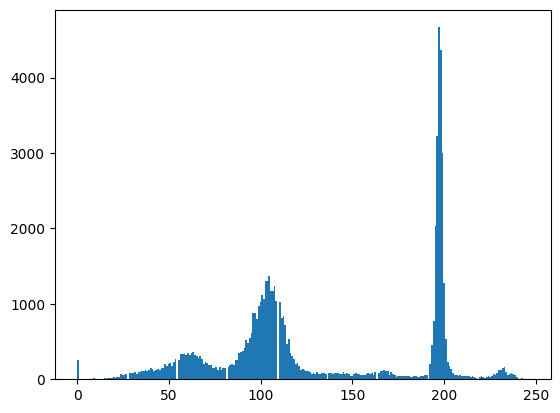

In [3]:
im=skio.imread('images/maison.tif')
imfloat= np.float32(im)

plt.hist(imfloat.reshape((-1,)),bins=255) #le reshape transforme en tableau 1D
plt.show()

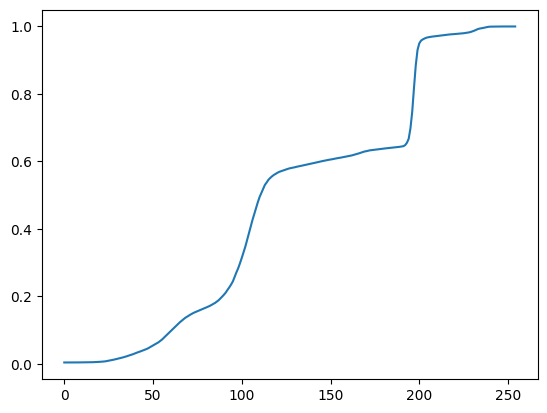

In [4]:
#calcul d'un histogramme cumule
(histo,bins)=np.histogram(im.reshape((-1,)),np.arange(0,256)) #le reshape est inutile pour np.histogram, mais on le laisse pour la compatibilite avec plt.hist
histo=histo/histo.sum()
histocum=histo.cumsum()
plt.plot(histocum)

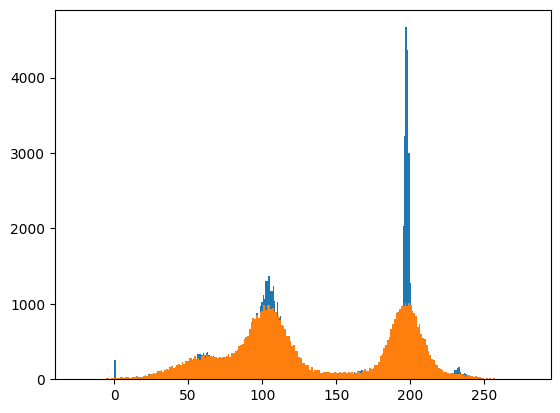

In [32]:
imbr = noise(im, 10)
#effet sur l'histogramme
plt.hist(im.reshape((-1,)), 255)
plt.hist(imbr.reshape((-1,)), 255)
plt.show()

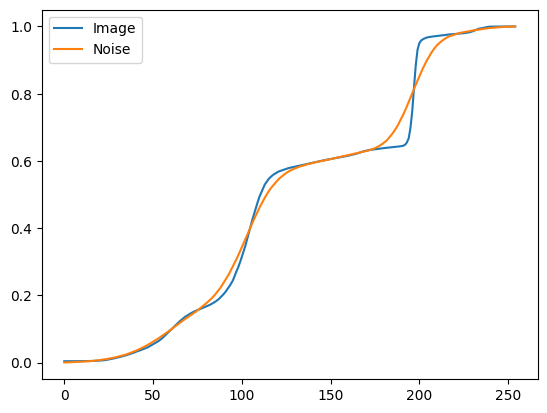

In [25]:
#calcul d'un histogramme cumule
(histo,bins)=np.histogram(im.reshape((-1,)),np.arange(0,256)) #le reshape est inutile pour np.histogram, mais on le laisse pour la compatibilite avec plt.hist
histo=histo/histo.sum()
histocum=histo.cumsum()
plt.plot(histocum, label='Image')

#calcul d'un histogramme cumule
(histo,bins)=np.histogram(imbr.reshape((-1,)),np.arange(0,256)) #le reshape est inutile pour np.histogram, mais on le laisse pour la compatibilite avec plt.hist
histo=histo/histo.sum()
histocum=histo.cumsum()
plt.plot(histocum, label='Noise')

plt.legend(['Image', 'Noise'])



In [35]:
im = skio.imread('images/sombre.jpg')
im = im.mean(axis=2)  #on est sur que l'image est grise
viewimage(im)
(histo, bins) = np.histogram(im.reshape((-1,)), np.arange(0,
                                                          256))  #le reshape en inutile pour np.histogram, mais on le laisse pour la compatibilite avec plt.hist
histo = histo / histo.sum()
histocum = histo.cumsum()
imequal = histocum[np.uint8(im)]
viewimage(imequal)

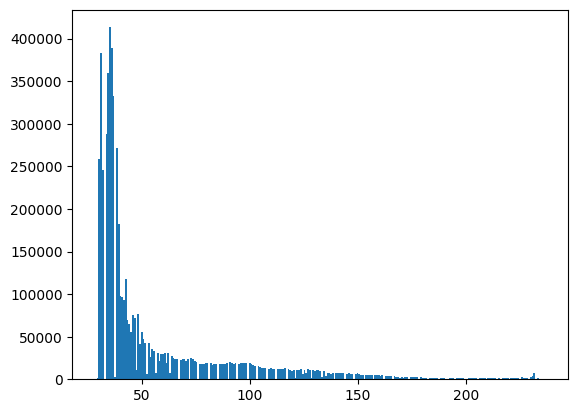

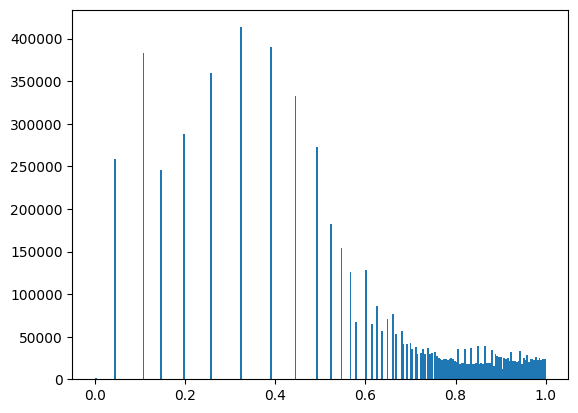

In [40]:
plt.hist(im.reshape((-1,)), 255)
plt.show()
plt.hist(imequal.reshape((-1,)), 255)
plt.show()

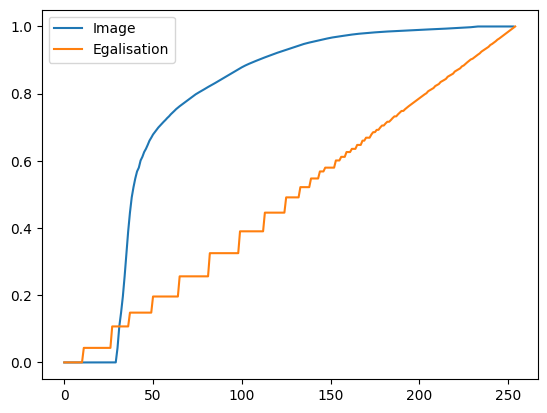

In [47]:
(histo,bins)=np.histogram(im.reshape((-1,)),np.arange(0,255)) #le reshape est inutile pour np.histogram, mais on le laisse pour la compatibilite avec plt.hist
histo=histo/histo.sum()
histocum=histo.cumsum()
plt.plot(histocum, label='Image')

#calcul d'un histogramme cumule
(histo,bins)=np.histogram(imequal.reshape((-1,)),bins=255) #le reshape est inutile pour np.histogram, mais on le laisse pour la compatibilite avec plt.hist
histo=histo/histo.sum()
histocum=histo.cumsum()
plt.plot(histocum)

plt.legend(['Image', 'Egalisation'])

###  3.4

In [13]:
u=skio.imread('images/vue1.tif')
v=skio.imread('images/vue2.tif')
viewimage(u)
viewimage(v)
# TEXTE1 dans le texte du tp
ind=np.unravel_index(np.argsort(u, axis=None), u.shape) #unravel donne les index 2D a partir des index 1d renvoyes par argsort (axis=None)
unew=np.zeros(u.shape,u.dtype)
unew[ind]=np.sort(v,axis=None)
viewimage(unew) #u avec l'histogramme de v

In [14]:
ushape=u.shape
uligne=u.reshape((-1,)) #transforme en ligne
vligne=v.reshape((-1,))
ind=np.argsort(uligne)
unew=np.zeros(uligne.shape,uligne.dtype)
unew[ind]=np.sort(vligne)
# on remet a la bonne taille
unew=unew.reshape(ushape)
viewimage(unew)


viewimage(abs(np.float32(u)-np.float32(v)))

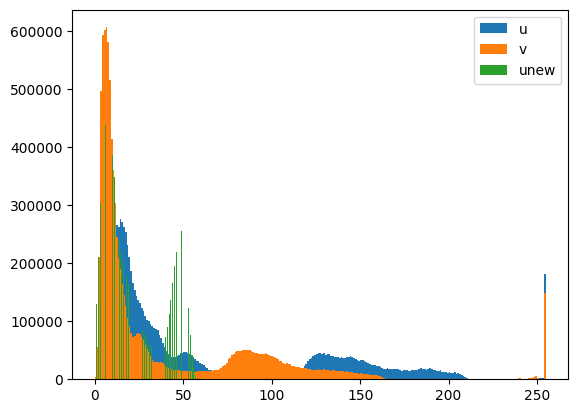

In [19]:
plt.hist(u.reshape((-1,)), 255)

plt.hist(v.reshape((-1,)), 255)


#plt.hist(unew.reshape((-1,)), 255)
plt.hist(abs(np.float32(u)-np.float32(v)).reshape((-1,)), 255)
plt.legend(['u', 'v' , 'unew'])
plt.show()

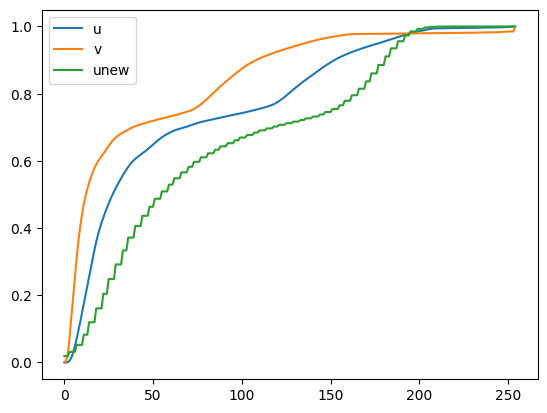

In [20]:
(histo,bins)=np.histogram(u.reshape((-1,)),np.arange(0,255)) #le reshape est inutile pour np.histogram, mais on le laisse pour la compatibilite avec plt.hist
histo=histo/histo.sum()
histocum=histo.cumsum()
plt.plot(histocum, label='Image')

#calcul d'un histogramme cumule
(histo,bins)=np.histogram(v.reshape((-1,)),bins=255) #le reshape est inutile pour np.histogram, mais on le laisse pour la compatibilite avec plt.hist
histo=histo/histo.sum()
histocum=histo.cumsum()
plt.plot(histocum)

(histo,bins)=np.histogram(abs(np.float32(u)-np.float32(v)).reshape((-1,)),bins=255) #le reshape est inutile pour np.histogram, mais on le laisse pour la compatibilite avec plt.hist
histo=histo/histo.sum()
histocum=histo.cumsum()
plt.plot(histocum)

plt.legend(['u', 'v' , 'unew'])
plt.show()

In [30]:
u=skio.imread('images/vue1.tif')
ushape = u.shape
uligne=u.reshape((-1,)) #makes image into horizontal vector
ind=np.argsort(uligne) #gives array of indexes that would sort uligne values 0...255
unew=np.zeros(uligne.shape,uligne.dtype) #create new empty image

# maps every point's value in the original image to a new unique value 
# while following the same order between the values of the points in the original
pixels = u.shape[0]*u.shape[1]
step_size = 255/pixels
unew[ind]=np.arange(0,255,step_size)

print(pixels)
print(unew[ind])
print(unew.shape)



10077696
[  0   0   0 ... 254 254 254]
(10077696,)


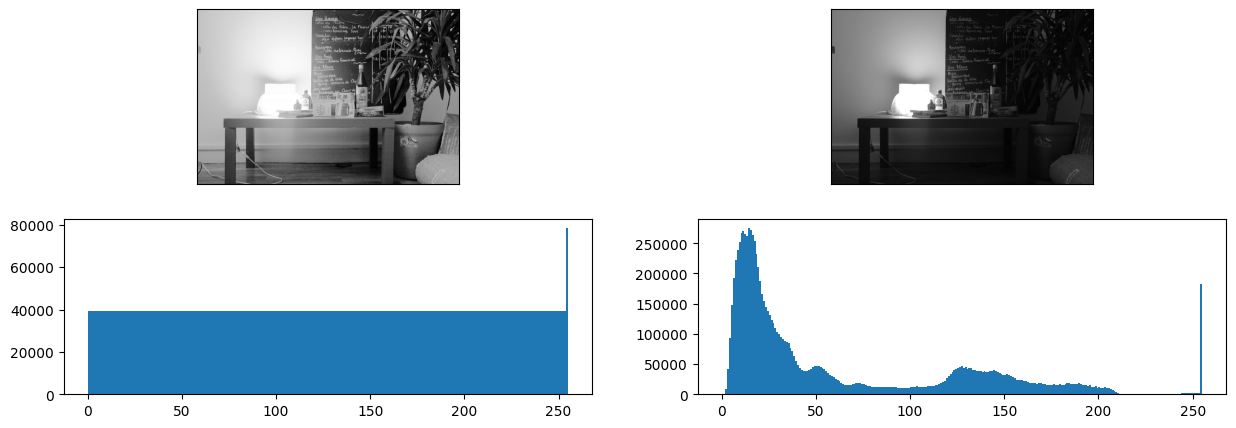

In [28]:
unew=unew.reshape(ushape) # shapes unew to the shape of u


fig, axes = plt.subplots(2, 2, figsize=(15, 5), gridspec_kw={'width_ratios': [1, 1]})

axes[0,0].imshow(unew,cmap='gray')
axes[0,0].set_xticks([])
axes[0,0].set_yticks([])
axes[0,1].imshow(u,cmap='gray')
axes[0,1].set_xticks([])
axes[0,1].set_yticks([])
histnew = axes[1,0].hist(unew.reshape(-1,),bins=np.arange(0,256))
hist = axes[1,1].hist(u.reshape(-1,),bins=np.arange(0,256))

### 3.5

In [27]:
im=skio.imread('images/maison.tif')
im2=quantize(im,2)
viewimage(im2)


viewimage(seuil(noise(im,40),128)) #exemple de dithering

viewimage(seuil(im,128)) #exemple de dithering

In [29]:
viewimage(seuil(noise(im,40),128)) #exemple de dithering

In [28]:
viewimage(seuil(im,128)) #exemple de dithering

In [30]:
viewimage(im) #exemple de dithering

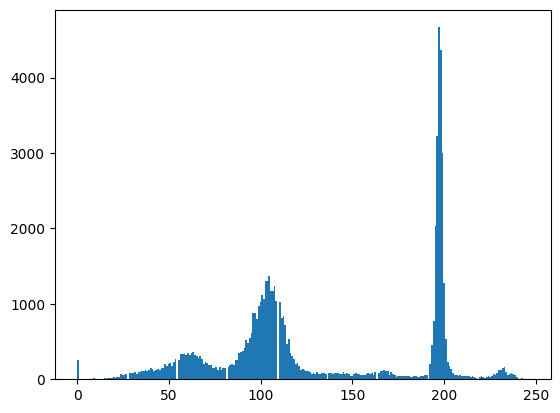

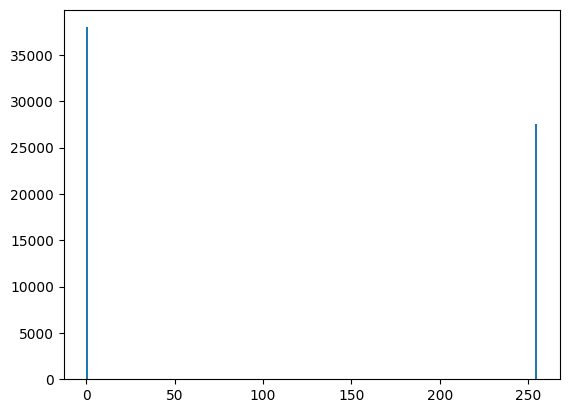

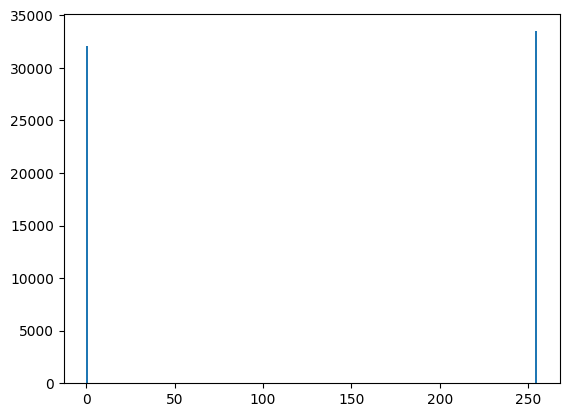

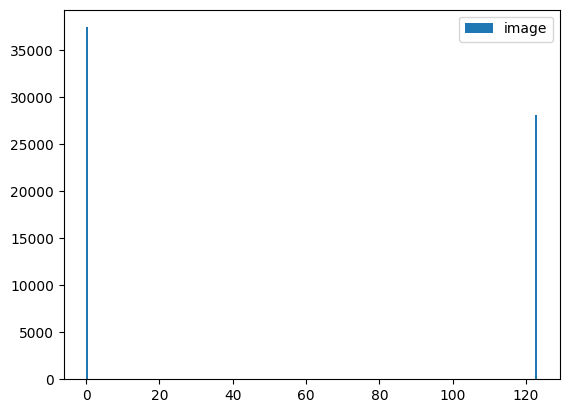

In [32]:
plt.hist(im.reshape((-1,)), 255)
plt.show()
plt.hist(seuil(im,128).reshape((-1,)), 255)
plt.show()
plt.hist(seuil(noise(im,40),128).reshape((-1,)), 255)
plt.show()
plt.hist(quantize(im,2).reshape((-1,)), 255)

#plt.hist(unew.reshape((-1,)), 255)
plt.legend(['image', 'seuil sans bruit' , 'seuil avec bruit', 'quantize'])
plt.show()

### 3.6

C:\Users\juane\AppData\Local\Temp\ipykernel_2212\616310952.py:1: RuntimeWarning: divide by zero encountered in log
  plt.plot(np.log(np.histogram(gradx(im),255)[0]))


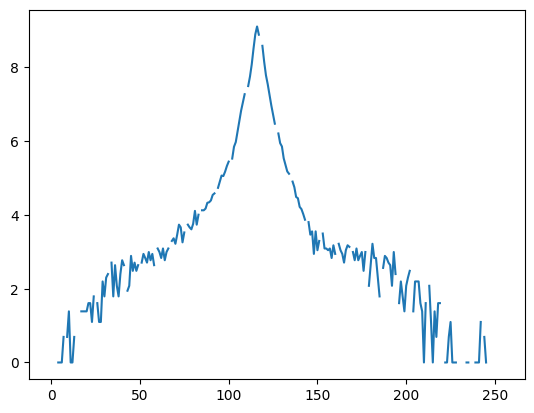

In [34]:
plt.plot(np.log(np.histogram(gradx(im),255)[0]))
plt.show()

## Section 4

In [35]:
im=skio.imread('images/lena.tif')
viewimage(im )
view_spectre(im,option=2,hamming=True)
view_spectre(im,option=2,hamming=False)

In [39]:
im=skio.imread('images/rayures.tif')
viewimage(im )




In [40]:
view_spectre(im,option=2,hamming=True)


In [41]:
view_spectre(im,option=2,hamming=False)

In [33]:
im=skio.imread('images/carte_nb.tif')
viewimage(im )
view_spectre(im,option=2,hamming=True)
view_spectre(im,option=2,hamming=False)

In [37]:
im=skio.imread('images/maison.tif')
viewimage(im )
view_spectre(im,option=2,hamming=True)
view_spectre(im,option=2,hamming=False)

In [38]:
imbr = noise(im, 10)
viewimage(imbr )
view_spectre(imbr,option=2,hamming=True)
view_spectre(imbr,option=2,hamming=False)

### 4.2

In [42]:
im = skio.imread('images/masque_bas_centre.tif')
viewimage(im )
view_spectre(im,option=2,hamming=True)

In [43]:
im_filtre = filterlow(im)

viewimage(im_filtre)
view_spectre(im_filtre,option=2,hamming=True)

In [46]:
im = skio.imread('images/masque_gauss_centre.tif')
viewimage(im )
view_spectre(im,option=2,hamming=True)

In [47]:
im_filtre = filtergauss(im)

viewimage(im_filtre)
view_spectre(im_filtre,option=2,hamming=True)